# Custom NER with Transformers

## Load the data

We load the data and determine the set of all tags as before:

In [1]:
MAX_LEN = 50

def load_data(filename: str):
    samples = []
    with open(filename, 'r') as file:
        sentence = []
        for line in file:
            line = line[:-1] # trim newline
            if line:
                token, full_tag = line.split()
                tag = full_tag.split('-')[-1]
                sentence.append((token, tag))
            else:
                samples.append(sentence[:MAX_LEN])
                sentence = []
    return samples

TRAIN_FILE = 'data/legal/01_raw/bag.conll'
train_samples = load_data(TRAIN_FILE)

VAL_FILE = 'data/legal/01_raw/bgh.conll'
val_samples = load_data(VAL_FILE)

schema = ['_'] + sorted({tag
                         for sentence in train_samples + val_samples
                         for _, tag in sentence})
print(' '.join(schema))

_ AN EUN GRT GS INN LD LDS LIT MRK O ORG PER RR RS ST STR UN VO VS VT


The data is now stored as a list of token-tag-pairs:

In [2]:
train_samples[3][:14]

[('Die', 'O'),
 ('beabsichtigte', 'O'),
 ('Klage', 'O'),
 ('auf', 'O'),
 ('Entschädigung', 'O'),
 ('wegen', 'O'),
 ('der', 'O'),
 ('Dauer', 'O'),
 ('des', 'O'),
 ('Verfahrens', 'RS'),
 ('vor', 'RS'),
 ('dem', 'RS'),
 ('Bundesarbeitsgericht', 'RS'),
 ('zum', 'RS')]

## Loading the BERT transformer model

The library [huggingface/transformers](https://huggingface.co/transformers) provides many
- **pre-trained** state-of-the-art **transformer models** like BERT, GPT-2 and others,
- model **wrappers for downstream tasks** like classification, named entity recognition, summarization,
- ways to use these models, e.g. in end-to-end pipelines or via TensorFlow or PyTorch.

We shall use

- a **BERT transformer** pre-trained on German,
- wrapped for **token classification**
- in form of a TensorFlow model.

Like most of the transformer models, BERT is quite large and loading it may take some time:


In [3]:
from transformers import AutoConfig, TFAutoModelForTokenClassification, AutoTokenizer
import tensorflow as tf

MODEL_NAME = 'bert-base-german-cased' # another option would be 'german-nlp-group/electra-base-german-uncased' 

def build_model(extra_metrics=[]):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
    model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, config=config)
    optimizer = tf.keras.optimizers.Adam(lr=0.00001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'] + extra_metrics)
    return tokenizer, model

tokenizer, model = build_model()
model.summary()

2021-09-28 15:48:47.641152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-28 15:48:47.641166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-28 15:48:53.692816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-28 15:48:53.692875: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-28 15:48:53.692925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-10-51-235.eu-central-1.compute.internal): /proc/driver/nvidia/version does not exist
2021-09-28 15:48:53.693474: I t

Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108490752 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  16149     
Total params: 108,506,901
Trainable params: 108,506,901
Non-trainable params: 0
_________________________________________________________________


/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


We obtain an honest Keras model. Alternatively, we could have used the PyTorch interface of huggingface transformers.

## Preprocessing


The transformer models are usually pre-trained with **sub-word-level tokenizers**. 

*The same tokenizers need to be used for the preprocessing.* That's why we loaded it together with the Bert model.

The tokenizer used by BERT will treat most common words as one token, but may split rare words into word pieces to avoid the out-of-vocabulary problem:

In [8]:
for utterance in ['Das', 'Das ist', 'Das ist eine hoch interessante Frage', 'Das ist eine hochinteressante Frage']:
    print(tokenizer(utterance))

{'input_ids': [3, 295, 4], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}
{'input_ids': [3, 295, 127, 4], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
{'input_ids': [3, 295, 127, 155, 2426, 23181, 1685, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [3, 295, 127, 155, 2426, 21477, 5004, 1685, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


Accordingly, we need to adjust the token label. We do so using the function `tokenize_sample` below:

In [11]:
def tokenize_sample(sample):
    seq = [(subtoken, tag) for token, tag in sample for subtoken in tokenizer(token)['input_ids'][1:-1]]
    return [(3, 'O')] + seq + [(4, 'O')]

For our samples, the length of the subword sequence will usually be longer than that of the corresponding word sequences:

In [13]:
print((train_samples[1]))
print((tokenize_sample(train_samples[1])))

[('Der', 'O'), ('Antrag', 'O'), ('auf', 'O'), ('Gewährung', 'O'), ('von', 'O'), ('Prozesskostenhilfe', 'O'), ('nebst', 'O'), ('Beiordnung', 'O'), ('von', 'O'), ('Herrn', 'O'), ('Rechtsanwalt', 'O'), ('F', 'AN'), ('für', 'O'), ('die', 'O'), ('beabsichtigte', 'O'), ('Einlegung', 'O'), ('einer', 'O'), ('Entschädigungsklage', 'O'), ('hinsichtlich', 'O'), ('der', 'O'), ('Dauer', 'O'), ('des', 'O'), ('Verfahrens', 'RS'), ('vor', 'RS'), ('dem', 'RS'), ('Bundesarbeitsgericht', 'RS'), ('zum', 'RS'), ('Aktenzeichen', 'RS'), ('-', 'RS'), ('8', 'RS'), ('AZR', 'RS'), ('418/15', 'RS'), ('-', 'RS'), ('wird', 'O'), ('zurückgewiesen', 'O'), ('.', 'O')]
[(3, 'O'), (233, 'O'), (846, 'O'), (115, 'O'), (8698, 'O'), (88, 'O'), (12663, 'O'), (2821, 'O'), (7218, 'O'), (467, 'O'), (1337, 'O'), (88, 'O'), (7010, 'O'), (6143, 'O'), (64, 'AN'), (142, 'O'), (30, 'O'), (18308, 'O'), (198, 'O'), (2351, 'O'), (225, 'O'), (14094, 'O'), (575, 'O'), (477, 'O'), (3792, 'O'), (21, 'O'), (4385, 'O'), (91, 'O'), (3040, 'RS'

We now apply the subword-level tokenization to our samples. This may take a few moments:

In [14]:
import numpy as np
from tqdm import tqdm

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_val, y_val = preprocess(val_samples)
X_train.shape, X_val.shape

12791it [00:14, 904.03it/s]
5858it [00:07, 828.56it/s]


((12791, 103), (5858, 109))

## Training

We can train the model just as we trained the bi-LSTM network, but now we need more resources:

In [15]:
import pandas as pd

def train(model, nr_samples=-1, epochs=1, batch_size=16):
    history = model.fit(tf.constant(X_train[:nr_samples]), tf.constant(y_train[:nr_samples]),
                        validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return model, pd.DataFrame(history.history)

Let's see whether everything works:

In [16]:
_, model = build_model()
model, history = train(model, nr_samples=100, epochs=1)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2021-09-28 16:02:04.008505: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 37s 5s/step - loss: 2.1220 - accuracy: 0.5013 - val_loss: 1.4314 - val_accuracy: 0.5990


This looks promising and resource-hungry.

To get more insight into the training process, let us track, for each tag, the accuracy for the one-vs-all classification:

In [17]:
import tensorflow as tf

def build_tag_accuracy(index, name):
    def tag_accuracy(y_true, y_pred):
        y_pred_index = tf.math.argmax(y_pred, axis=-1)
        y_t_b = y_true == index
        y_p_b = y_pred_index == index
        return tf.reduce_mean(tf.where(y_t_b == y_p_b, 1.0, 0.0))

    tag_accuracy.__name__ = 'accuracy_' + name
    return tag_accuracy

tags_metrics = [build_tag_accuracy(index, name) for index, name  in enumerate(schema)]


In [18]:
_, model = build_model(tags_metrics)
model, history = train(model, nr_samples=20, epochs=2)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1/1 [==============================] - 15s 15s/step - loss: 3.1296 - accuracy: 0.0164 - accuracy__: 0.3792 - accuracy_AN: 0.9891 - accuracy_EUN: 0.9854 - accuracy_GRT: 0.9830 - accuracy_GS: 0.9248 - accuracy_INN: 0.9964 - accuracy_LD: 0.9988 - accuracy_LDS: 0.9084 - accuracy_LIT: 0.9763 - accuracy_MRK: 0.9260 - accuracy_O: 0.6905 - accuracy_ORG: 0.9830 - accuracy_PER: 0.9897 - accuracy_RR: 0.9836 - accuracy_RS: 0.9059 - accuracy_ST: 0.6553 - accuracy_STR: 0.8544 - accuracy_UN: 0.9976 - accuracy_VO: 0.9873 - accuracy_VS: 0.9430 - accuracy_VT: 0.9751 - val_loss: 2.5305 - val_accuracy: 0.5146 - val_accuracy__: 0.8155 - val_accuracy_AN: 0.9903 - val_accuracy_EUN: 0.9782 - val_accuracy_GRT: 0.9539 - val_accuracy_GS: 0.9417 - val_accuracy_INN: 0.9951 - val_accuracy_LD: 0.9976 - val_accuracy_LDS: 0.9903 - val_accuracy_LIT: 0.9296 - val_accuracy_MRK: 0.9539 - val_accuracy_O: 0.7015 - val_accuracy_ORG: 0.9806 - val_accuracy_PER: 0.9879 - val_accuracy_RR: 0.9951 - val_accuracy_RS: 0.91

Before we take more time to train the model on real data, let us see how to apply and evaluate the model:

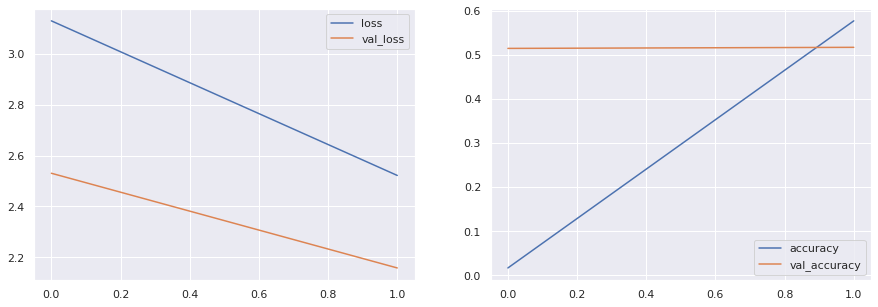

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    history[['loss', 'val_loss']].plot.line(ax=ax1)
    history[['accuracy', 'val_accuracy']].plot.line(ax=ax2)

plot_history(history)

## Evaluation

The model can be applied as follows:

In [20]:
sample_index = 5
probs = model.predict(X_val[sample_index: sample_index + 1])[0][0]
preds = np.argmax(probs, axis=-1)
probs.shape, preds.shape

((109, 21), (109,))

Now comes an important point:

To compare the results obtained with BERT to other approaches, we should evaluate the predictions 

- not on the level of the subword token produced by our model-coupled tokenizer
- but on the level of the words as they appear in the dataset!

Remember that a long and rare word that comes with one tag in the dataset might be split up into several token by the tokenizer and then each of these token will be tagged separately by the BERT model. We need to collect all these tags and decide, e.g. by a majority vote, which of the tags should be chosen for the entire token.

For the majority vote, we use NumPy as follows

In [21]:
def majority_vote(votes):
    return np.argmax(np.histogram(votes, bins=len(schema), range=(0, len(schema)))[0])

majority_vote(np.array([1,2,1,0,3,1,4]))

1

Now we need to align the predictions: 

In [22]:
def align_predictions(sample, predictions):
    results = []
    i = 1
    for token, y_true in sample:
        nr_subtoken = len(tokenizer(token)['input_ids']) -2 # beware of start- and end-token
        votes = predictions[i:i+nr_subtoken]
        i += nr_subtoken
        y_pred = schema[majority_vote(votes)]
        y_pred_sub = ''.join(schema[p] for p in votes)
        results.append((token, y_true, y_pred, y_pred_sub))
    return results

pd.DataFrame(align_predictions(val_samples[sample_index], preds)[:20], columns= ['Token', 'Truth', 'Prediction', 'Sub-Predictions'])

Token Truth Prediction Sub-Predictions
0                 Das     O        MRK             MRK
1         Landgericht     O          _               _
2                 hat     O        ORG             ORG
3                 den     O         VO              VO
4         Angeklagten     O          _               _
5               wegen     O         RS              RS
6             Einfuhr     O         RS            RSRS
7                 von     O         RS              RS
8   Betäubungsmitteln     O         RS          RSRSRS
9                  in     O         RS              RS
10              nicht     O         GS              GS
11           geringer     O        STR             STR
12              Menge     O        GRT             GRT
13                 in     O         RS              RS
14         Tateinheit     O         RS            RSRS
15                mit     O         RS              RS
16           Beihilfe     O         RS              RS
17                zum     O        STR             STR
18      Handeltreiben     O         RS        RSRSRSRS
19                mit     O         RS              RS

We can now predict on the validation set as follows:

In [23]:
def predict(model, nr_val_samples=-1):
    y_probs = model.predict(X_val[:nr_val_samples])[0]
    y_preds = np.argmax(y_probs, axis=-1)
    return [align_predictions(sample, predictions) for sample, predictions in zip(val_samples, y_preds)]

predictions = predict(model, nr_val_samples=10)


Finally, we evaluate the predictions on the level of token as a one-vs-all classification problem:

In [24]:
from sklearn.metrics import classification_report

def evaluate(predictions):
    y_t = [pos[1] for sentence in predictions for pos in sentence]
    y_p = [pos[2] for sentence in predictions for pos in sentence]
    report = classification_report(y_t, y_p, output_dict=True)
    return pd.DataFrame.from_dict(report).transpose().reset_index()

scores = evaluate(predictions)
print(scores)

           index  precision    recall  f1-score     support
0             AN   0.000000  0.000000  0.000000    0.000000
1            EUN   0.000000  0.000000  0.000000    0.000000
2            GRT   0.250000  0.125000  0.166667    8.000000
3             GS   0.111111  0.041667  0.060606   24.000000
4            LDS   0.000000  0.000000  0.000000    0.000000
5            LIT   0.000000  0.000000  0.000000   19.000000
6            MRK   0.000000  0.000000  0.000000    0.000000
7              O   1.000000  0.023166  0.045283  259.000000
8            ORG   0.000000  0.000000  0.000000    0.000000
9            PER   0.000000  0.000000  0.000000    0.000000
10            RR   0.000000  0.000000  0.000000    0.000000
11            RS   0.025000  0.066667  0.036364   15.000000
12            ST   0.000000  0.000000  0.000000    0.000000
13           STR   0.000000  0.000000  0.000000    0.000000
14            VO   0.000000  0.000000  0.000000    0.000000
15            VS   0.000000  0.000000  0

/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2021/nlp-20210924-notebooks/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control th